In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import pickle as pkl

import starry
import astropy.units as u
import jwst as jwst

import jax.numpy as jnp
from jax import random, jit, vmap, lax
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import *

from volcano.utils import *

numpyro.enable_x64()
np.random.seed(42)
starry.config.lazy = False

In [2]:
%matplotlib inline
%run notebook_setup.py

In [3]:
nircam_filters = jwst.get_nircam_filter_wheel()
filt = nircam_filters[0]
for filter in nircam_filters:
    print("%s : %.1f um" % (filter.name, filter.eff_wl))

F444W : 4.4 um


In [4]:
# Load data
with open('super_earth_lc.pkl', 'rb') as handle:
    lc = pkl.load(handle)
with open('super_earth_star_params.pkl', 'rb') as handle:
    params_s = pkl.load(handle)
with open('super_earth_planet_params.pkl', 'rb') as handle:
    params_p = pkl.load(handle)
with open('super_earth_metadata.pkl', 'rb') as handle:
    metadata = pkl.load(handle)

# Exponential prior

In [5]:
f_obs = lc.obs
f_err = lc.sig

In [6]:
ydeg_inf = 12

star = starry.Primary(
    starry.Map(ydeg=0),
    r=params_s["r"],
    m=params_s["m"],
    prot=params_s["prot"],
)

planet = starry.Secondary(
    starry.Map(
        ydeg=ydeg_inf,
        inc=params_p["inc"],
    ),
    r=params_p["r"],
    m=params_p["m"],
    porb=params_p["porb"],
    prot=params_p["prot"],
    t0=params_p["t0"],
    inc=params_p["inc"],
)
texp = metadata['texp']
sys_fit = starry.System(star, planet, texp=(texp.to(u.d)).value, oversample=9, order=0)

Pre-computing some matrices... Done.


In [7]:
# Design matrix
t = lc.time
A = sys_fit.design_matrix(t)[:, 1:]
r = sys_fit.position(t)

x_prim = r[0][0][:]
y_prim = r[1][0][:]
x_sec = r[0][1][:]
y_sec = r[1][1][:]

xo = x_prim - x_sec
yo = y_prim - y_sec
ro = sys_fit.primary.r/sys_fit.secondaries[0].r

Compiling `X`... Done.
Compiling `position`... Done.


In [8]:
# Fit single map model with different map amplitudes for ingress and egress
map = starry.Map(ydeg_inf)
lat, lon, Y2P, P2Y, Dx, Dy = map.get_pixel_transforms(oversample=4)
npix = Y2P.shape[0]

Y2P = jnp.array(Y2P)
P2Y = jnp.array(P2Y)
Dx = jnp.array(Dx)
Dy = jnp.array(Dy)

Pre-computing some matrices... Done.
Compiling `RAxisAngle`... Done.
Compiling `pT`... Done.


# Exponential prior

In [9]:
# mask = np.logical_and((t*24*60 > -560),  (t*24*60 < -500))

def model():
    p = numpyro.sample('p', dist.Exponential(1/1).expand([npix]))
    x = jnp.dot(P2Y, p)
    amp_planet = numpyro.sample("amp_planet", dist.LogNormal(-8, 4))
#     amp_planet = numpyro.sample("amp_planet", dist.Uniform(0, 0.1))
    x *= amp_planet

    # Run the smoothing filter
    S = jnp.array(get_smoothing_filter(ydeg_inf, 2. / ydeg_inf))
    x_s = jnp.dot(S, x[:, None]).reshape(-1)
    numpyro.deterministic('x', x_s)
    
#     flux_star = numpyro.sample("flux_star", dist.Normal(np.median(f_obs[mask]), 1e3*np.std(f_obs[mask])))

    flux = jnp.dot(A, x_s[:, None]).reshape(-1) + 1.
    numpyro.deterministic("fpred", flux)

    # Dense grid
#     flux_dense = jnp.dot(A_dense, x_s[:, None]).reshape(-1)
#     numpyro.deterministic("flux_dense", flux_dense)
    
    numpyro.sample("obs", dist.Normal(flux, f_err * np.ones_like(f_obs)), obs=f_obs)

In [10]:
init_vals = {
#     'flux_star':np.median(f_obs[mask]),
    'amp_planet':7e-05
}

nuts_kernel = NUTS(
    model,
    dense_mass=False,
    init_strategy=init_to_value(values=init_vals),
    target_accept_prob=0.95,
)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1500)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:32<00:00, 61.30it/s, 63 steps of size 7.45e-02. acc. prob=0.95]  


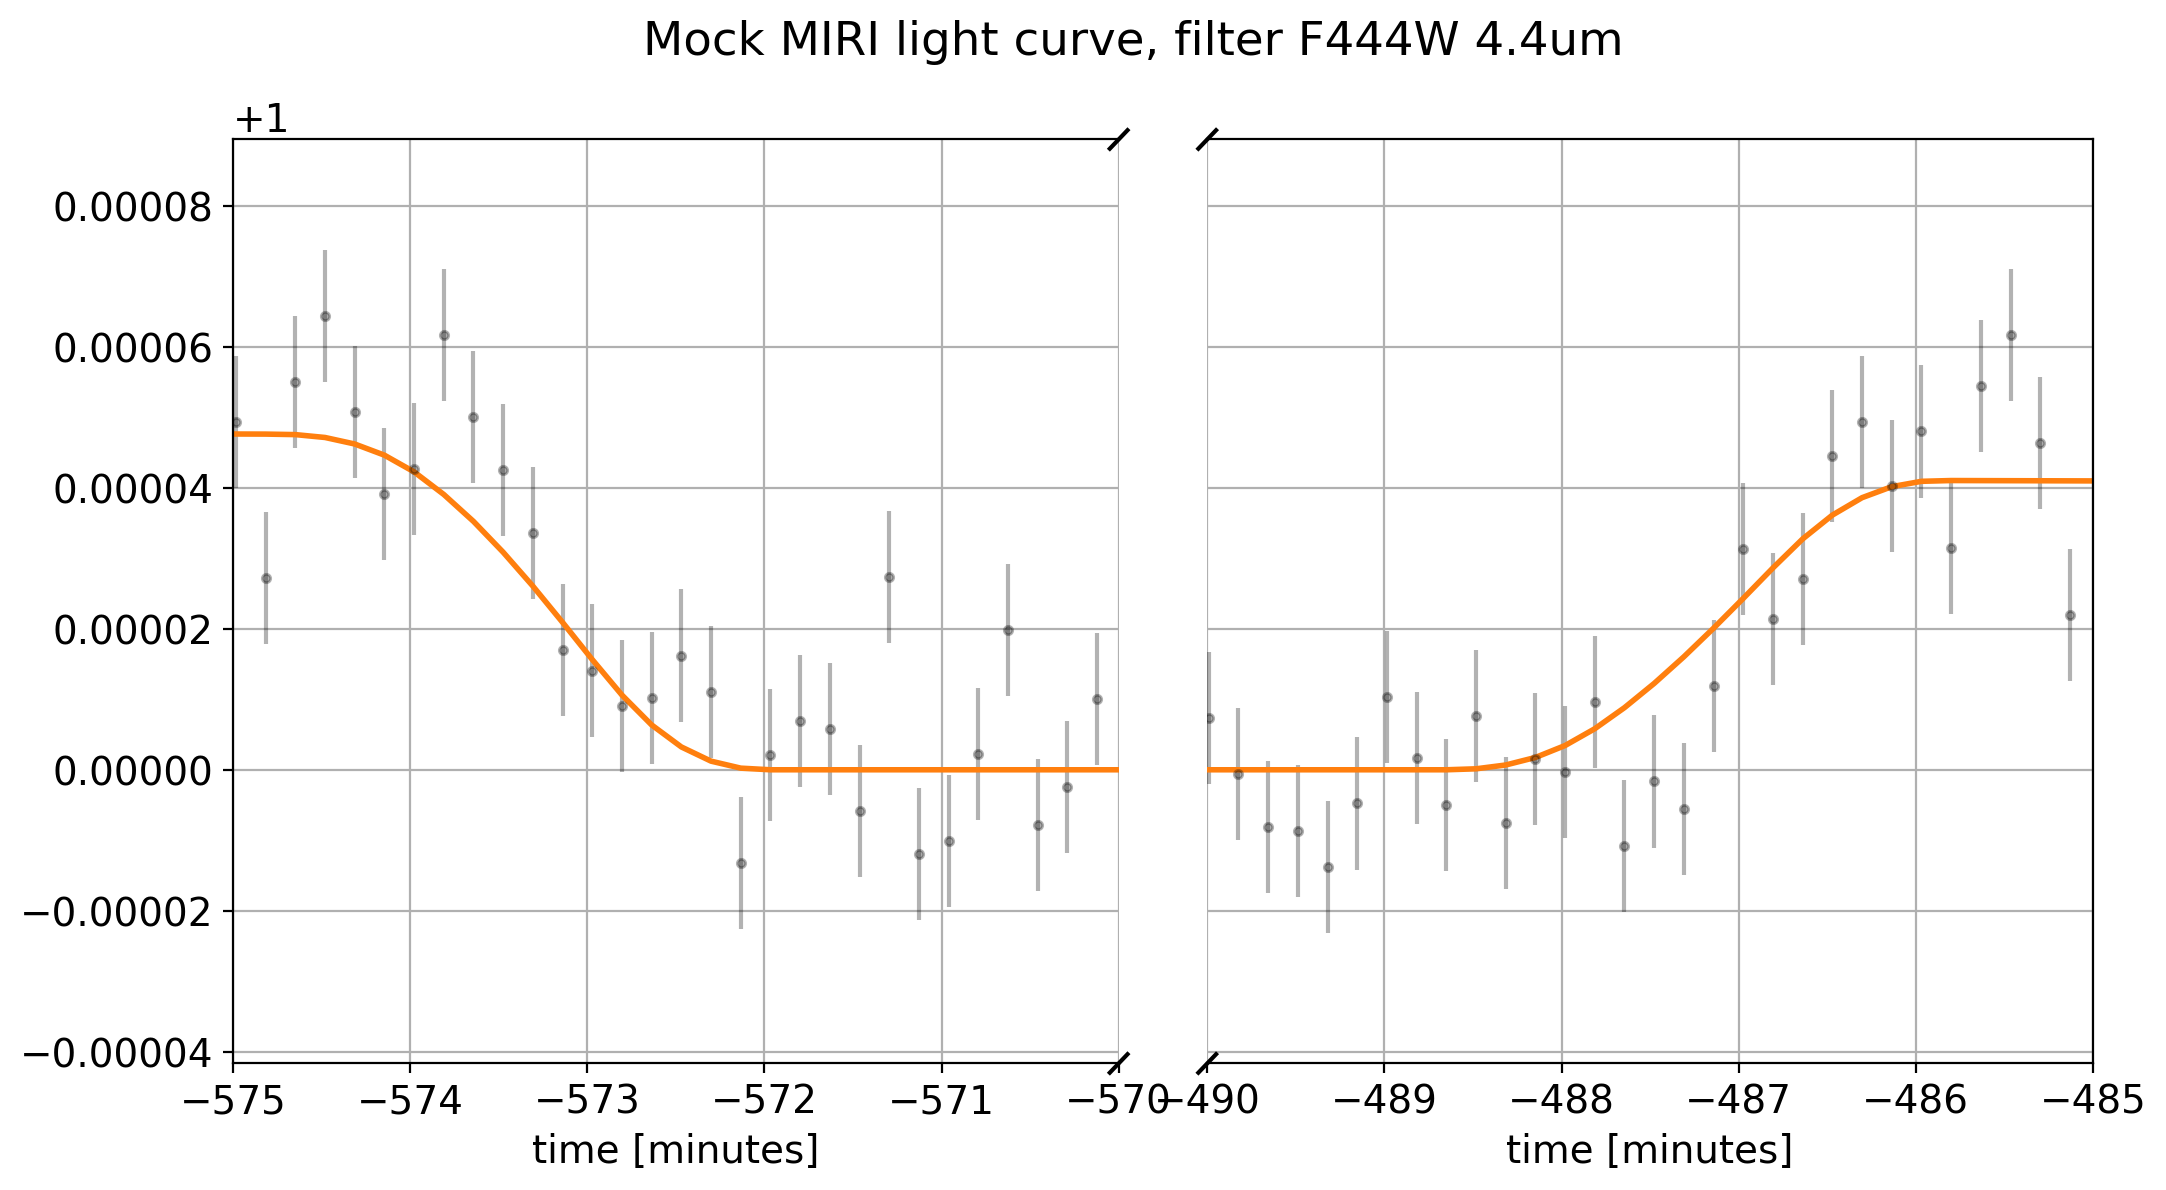

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={"wspace":0.1})

norm = np.median(lc.obs[:10])
ax[0].errorbar(
    lc.time*24*60,
    f_obs,
    f_err,
    fmt=".",
    color="black",
    alpha=0.3,
)
ax[1].errorbar(
    lc.time*24*60,
    f_obs,
    f_err,
    fmt=".",
    color="black",
    alpha=0.3,
)

ax[0].set_xlim(-575, -570)
ax[1].set_xlim(-490, -485)

fig.suptitle(f"Mock MIRI light curve, filter {filt.name} {filt.eff_wl:.1f}um")
# ax.set_xlim(-7.5, 7.5)

for a in ax.flatten():
    a.set_xlabel('time [minutes]')
    a.grid()

# Make broken axis
ax[0].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].tick_params(axis="y", colors=(0, 0, 0, 0))

d = 0.01
kwargs = dict(transform=ax[0].transAxes, color="k", clip_on=False)
ax[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax[1].transAxes)
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

for a in ax[:]:
    a.plot(t*24*60, np.median(samples['fpred'], axis=0), 'C1-', lw=2.)

In [12]:
median_map = get_median_map(ydeg_inf, samples['x'], projection=None, theta=180., nsamples=100)

Pre-computing some matrices... INFO:starry.ops:Pre-computing some matrices... 
Done.
INFO:starry.ops:Done.
Compiling `render`... INFO:starry.ops:Compiling `render`... 
Done.
INFO:starry.ops:Done.
/Users/fb90/anaconda3/envs/io_starry_reg/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Pre-computing some matrices... INFO:starry.ops:Pre-computing some matrices... 
Done.
INFO:starry.ops:Done.


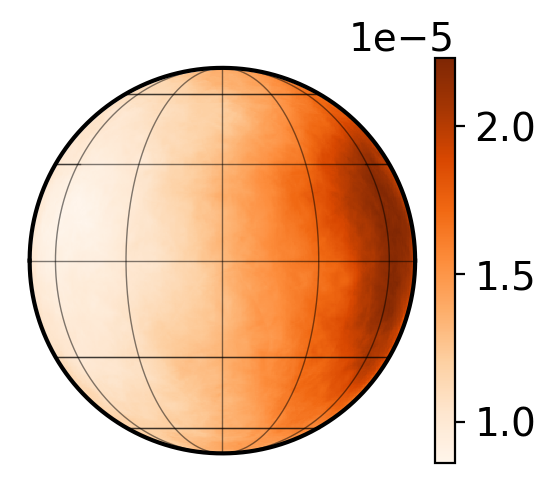

In [13]:
map = starry.Map(ydeg=ydeg_inf)
map.show(image=median_map, colorbar=True, cmap="Oranges")
#         norm=colors.Normalize(vmin=0., vmax=1))

# Regularized horseshoe prior

In [14]:
# Set the prior scale tau0 for the global scale parameter tau
D = npix
N = len(f_obs)
peff = 0.9*D # Effective number of parameters
sig = np.mean(f_err)
tau0 = peff/(D - peff)*sig/np.sqrt(len(f_obs))
print("tau0", tau0)

# Other constants for the model
slab_scale = 5.
slab_df = 20

def model():
    # Specify Finish Horseshoe prior
    # Non-centered distributions- loc=0, width=1 then shift/stretch afterwards
    beta_raw = numpyro.sample('beta_raw', dist.HalfNormal(1.).expand([D]))
    lamda_raw = numpyro.sample('lamda_raw', dist.HalfCauchy(1.).expand([D]))
    tau_raw = numpyro.sample('tau_raw', dist.HalfCauchy(1.))
    c2_raw = numpyro.sample('c2_raw', dist.InverseGamma(0.5*slab_df, 0.5*slab_df))

    # Do the shifting/stretching
    tau = numpyro.deterministic('tau', tau_raw*tau0)
    c2 = numpyro.deterministic('c2', slab_scale**2*c2_raw)
    lamda_tilde = numpyro.deterministic('lamda_tilde',
           jnp.sqrt(c2)*lamda_raw/jnp.sqrt(c2 + tau**2*lamda_raw**2)
    )
    numpyro.deterministic("mu_meff", (tau/sig*np.sqrt(N))/(1 + tau/sig*np.sqrt(N))*D)

    # The Finnish Horseshoe prior on p
    p = numpyro.deterministic('p', tau * lamda_tilde * beta_raw)
    x = jnp.dot(P2Y, p)
    
    amp_planet = numpyro.sample("amp_planet", dist.LogNormal(-5, 3))
    x *= amp_planet

    # Run the smoothing filter
    S = jnp.array(get_smoothing_filter(ydeg_inf, 2. / ydeg_inf))
    x_s = jnp.dot(S, x[:, None]).reshape(-1)
    numpyro.deterministic("x", x_s)
    
    flux = jnp.dot(A, x_s[:, None]).reshape(-1) + 1.
    numpyro.deterministic("fpred", flux)
    
    numpyro.sample("obs", dist.Normal(flux, f_err * np.ones_like(f_obs)), obs=f_obs)

tau0 2.876395662412646e-06


In [15]:
init_vals = {
    'beta_raw':0.5*jnp.ones(D),
    'lamda':jnp.ones(D),
    'tau_raw':0.1,
    'c2_raw':5**2,
    'amp_planet':7e-05
}

nuts_kernel = NUTS(
    model,
    dense_mass=False,
    init_strategy=init_to_value(values=init_vals),
    target_accept_prob=0.95,
)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1500)
rng_key = random.PRNGKey(1)
mcmc.run(rng_key)
samples2 = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [05:25<00:00,  6.14it/s, 1023 steps of size 2.21e-03. acc. prob=0.98]


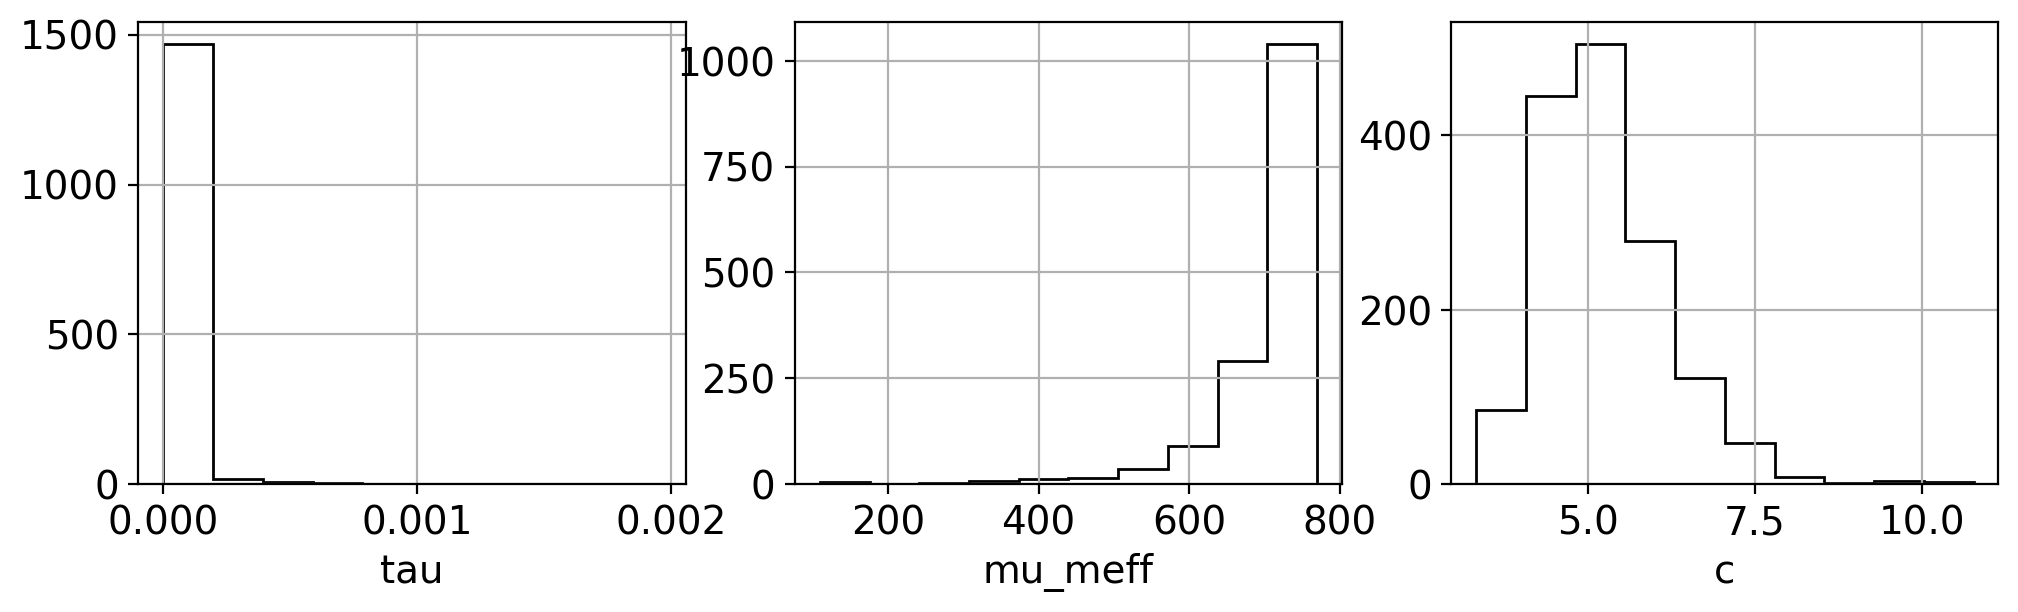

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].hist(samples2['tau'], histtype='step', color='black');
ax[0].set_xlabel('tau')
ax[1].hist(samples2['mu_meff'], histtype='step', color='black');
ax[1].set_xlabel('mu_meff')
ax[2].hist(np.sqrt(samples2['c2']), histtype='step', color='black');
ax[2].set_xlabel('c')
for a in ax.flatten(): a.grid()

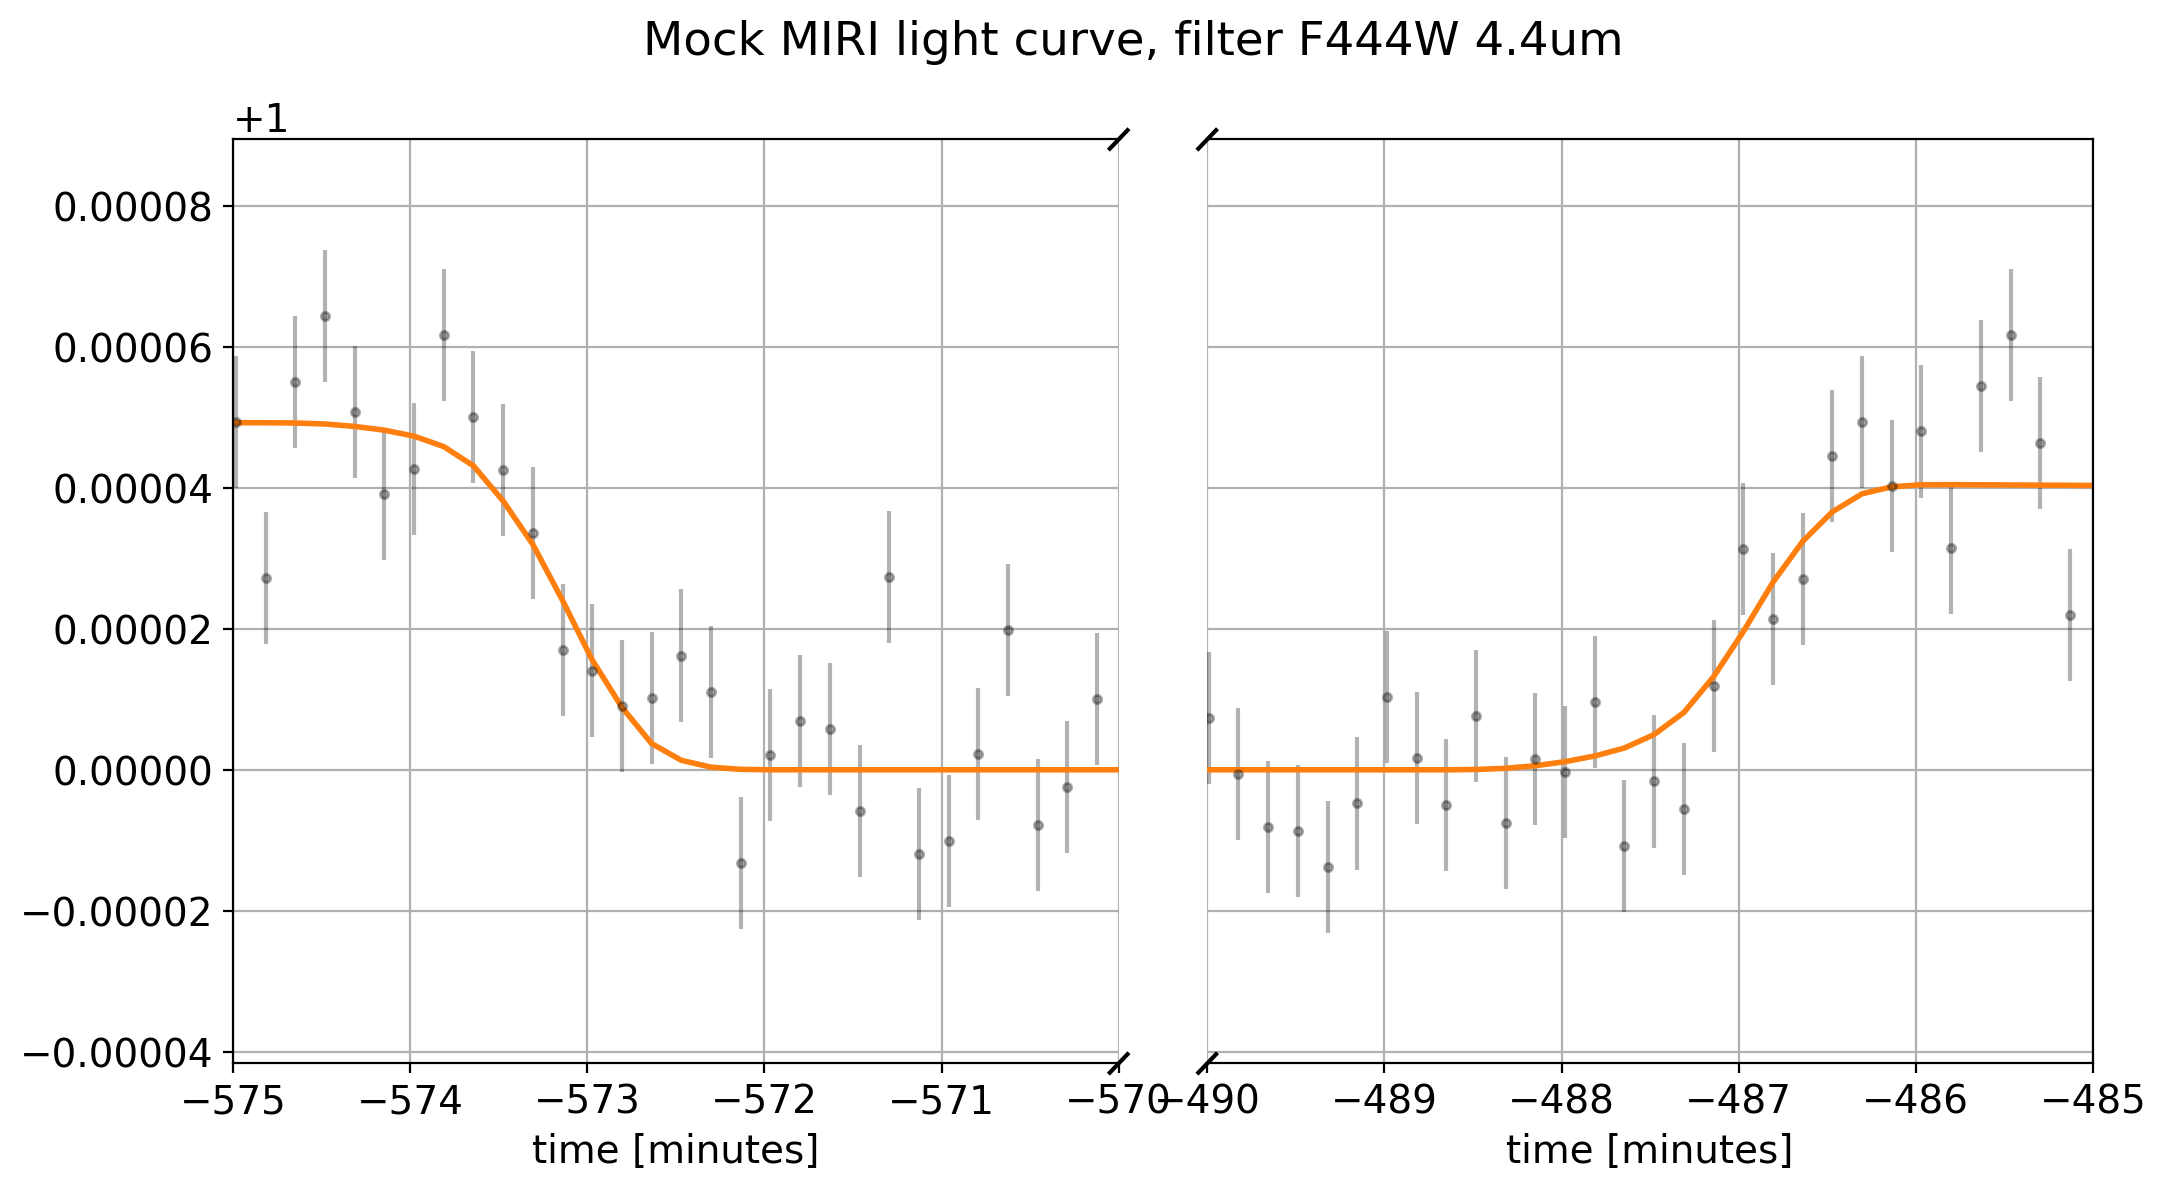

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={"wspace":0.1})

norm = np.median(lc.obs[:10])
ax[0].errorbar(
    lc.time*24*60,
    f_obs,
    f_err,
    fmt=".",
    color="black",
    alpha=0.3,
)
ax[1].errorbar(
    lc.time*24*60,
    f_obs,
    f_err,
    fmt=".",
    color="black",
    alpha=0.3,
)

ax[0].set_xlim(-575, -570)
ax[1].set_xlim(-490, -485)

fig.suptitle(f"Mock MIRI light curve, filter {filt.name} {filt.eff_wl:.1f}um")
# ax.set_xlim(-7.5, 7.5)

for a in ax.flatten():
    a.set_xlabel('time [minutes]')
    a.grid()

# Make broken axis
ax[0].spines["right"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].tick_params(axis="y", colors=(0, 0, 0, 0))

d = 0.01
kwargs = dict(transform=ax[0].transAxes, color="k", clip_on=False)
ax[0].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax[1].transAxes)
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax[1].plot((-d, +d), (-d, +d), **kwargs)

for a in ax[:]:
    a.plot(t*24*60, np.median(samples2['fpred'], axis=0), 'C1-', lw=2.)

In [22]:
# median_map_moll2 = get_median_map(ydeg_inf, samples2['x'])
median_map2 = get_median_map(ydeg_inf, samples2['x'], projection=None, theta=180., nsamples=200)

Pre-computing some matrices... INFO:starry.ops:Pre-computing some matrices... 
Done.
INFO:starry.ops:Done.
Compiling `render`... INFO:starry.ops:Compiling `render`... 
Done.
INFO:starry.ops:Done.
/Users/fb90/anaconda3/envs/io_starry_reg/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Pre-computing some matrices... INFO:starry.ops:Pre-computing some matrices... 
Done.
INFO:starry.ops:Done.


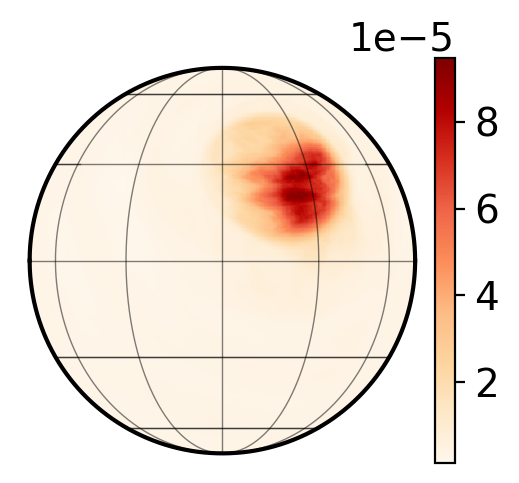

In [23]:
map = starry.Map(ydeg=ydeg_inf)
map.show(image=median_map2, colorbar=True, cmap="OrRd")
#         norm=colors.Normalize(vmin=0., vmax=1))